# Motors

In [1]:
# Vehicle = sm_car_vehcfg_setPower(Vehicle,'Ideal_A1_A2_default');
# Vehicle = sm_car_vehcfg_setPowerCooling(Vehicle,'None');

<hr>

# Passengers configurations

In [2]:
# Vehicle = sm_car_vehcfg_setPeopleOnOff(Vehicle,[1 1 0 0 0],'SuspA1');

<hr>

# adjusting the linearity of the dampers and springes

In [3]:
# Vehicle = sm_car_vehcfg_setSpring(Vehicle,'Axle2_Independent','SHLnonlinA1_SHLnonlinA2_None');
# Vehicle = sm_car_vehcfg_setDamper(Vehicle,'Axle2_Independent','SHLnonlinA1_SHLnonlinA2_None');

<hr>

# Configure Vehicle

In [4]:
# sm_car_config_vehicle('sm_car');

<hr>

In [5]:
# sm_car_config_maneuver('sm_car','WOT Braking');
# sm_car_config_maneuver('sm_car','Low Speed Steer');
# sm_car_config_maneuver('sm_car','Turn');
# sm_car_config_maneuver('sm_car','Straight Constant Speed');
# sm_car_config_maneuver('sm_car','Constant Radius Closed-Loop');
# sm_car_config_maneuver('sm_car','Double Lane Change');
# sm_car_config_maneuver('sm_car','Double Lane Change ISO3888');

<hr>

# Run Simulation

In [6]:
# sim(mdl)

<hr>

In [9]:
# driver FL_FR_RL_RR
Passengers_map = {'[1 1 0 0 0]':'FL',
                  '[1 1 1 0 0]':'FL_FR',
                  '[1 1 0 1 0]':'FL_RL',
                  '[1 1 0 0 1]':'FL_RR',
                  '[1 1 1 1 0]':'FL_FR_RL',
                  '[1 1 1 0 1]':'FL_FR_RR',
                  '[1 1 0 1 1]':'FL_RL_RR',
                  '[1 1 1 1 1]':'FL_FR_RL_RR'}

Maneuvers_m = ["'Double Lane Change'", "'WOT Braking'", "'Low Speed Steer'", "'Turn'", "'Straight Constant Speed'", "'Constant Radius Closed-Loop'", "'Double Lane Change ISO3888'"]

we need to manually excecute the command by mouse in matlab to know what line of code is scripted in the interactive shell of matlab
we then take this line and modify it to
the following script creates a full factorial desing of experiment and it exports it in a form .m script file that should be excecuted in matlab

<hr>

# Generate .txt file with name of all samples

In [8]:
# i = 0
# with open('names_of_files.txt', 'w') as fout:
#         for passenger_compination in Passengers_map.keys():
#             m = 'low_spd_ster'
#             sample=f'{i}_{m}_{Passengers_map[passenger_compination]}_{Accel_pedal}_{}\n'
#             #print(sample)
#             fout.writelines(sample)
#             i +=1

In [10]:
import numpy as np
from pyDOE2 import lhs

def latin_hypercube_sampling(n, ranges):
    num_vars = len(ranges)
    samples = lhs(num_vars, samples=n, criterion= 'maximin')
    for i in range(num_vars):
        lower_bound, upper_bound = ranges[i]
        samples[:, i] = samples[:, i] * (upper_bound - lower_bound) + lower_bound
    return samples

# Define the ranges for each variable
# Acceleration_Pedal_Pos_range = (0, 1)
# Steering_Angle_range = (-2, 2)

# # Combine the ranges into a list
# ranges = [Acceleration_Pedal_Pos_range, Steering_Angle_range]

# # Number of sample points
# n = 50  # You can adjust this to the desired number of samples

# # Generate the Latin Hypercube samples
# lhs_samples = latin_hypercube_sampling(n, ranges)

# # Print the generated samples
# for i, sample in enumerate(lhs_samples):
#     print(f'Sample {i + 1}: Acceleration_Pedal_Pos = {sample[0]}, Steering_Angle = {sample[1]}')


In [10]:
# accel untill 0.5 was okay

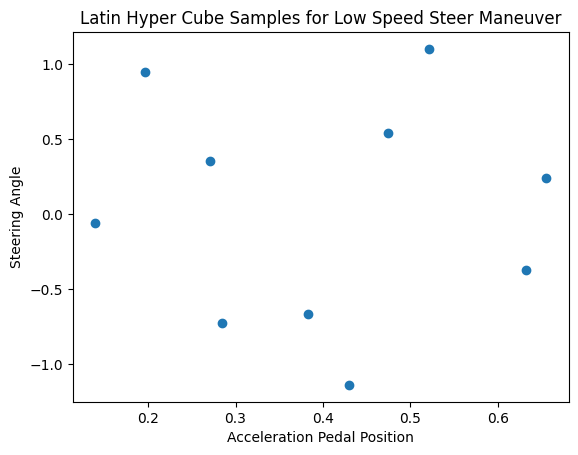

In [5]:
import matplotlib.pyplot as plt
# Define the ranges for each variable
Acceleration_Pedal_Pos_range = (0.1, 0.70)
Steering_Angle_range = (-1.2, 1.2)

# Combine the ranges into a list
ranges = [Acceleration_Pedal_Pos_range, Steering_Angle_range]

# Number of sample points
n = 10  # You can adjust this to the desired number of samples

# Generate the Latin Hypercube samples
lhs_samples = latin_hypercube_sampling(n, ranges)
fig, ax = plt.subplots()
ax.scatter(lhs_samples[:, 0], lhs_samples[:, 1])
# Add labels and a title
plt.xlabel('Acceleration Pedal Position')
plt.ylabel('Steering Angle')
plt.title('Latin Hyper Cube Samples for Low Speed Steer Maneuver')

# Show the plot
plt.show()

<hr>

# Generate Matlab Design of experiment script.m file

In [11]:
i = 0
with open('names_of_files_turn.txt', 'w') as fout_1:
    m = 'Turn'
    with open(f"doe_matlab_script_{m}.m", "w") as fout:
        for passenger_compination, passenger_compination_str in Passengers_map.items():
            fout.writelines(f"log_file = fopen('log_file_{m}.txt', 'w');\n")
            for sample in lhs_samples:
                i += 1
                acceleration_pedal_pos = sample[0]
                steering_angle = sample[1]
                # writing the name of the sample in a seperate file to rename it later
                sample=f'{i}_{m}_{passenger_compination_str}\n'
                fout_1.writelines(sample)
                # Initializing the model
                fout.writelines("mdl = 'sm_car';\n")
                # Setting brakes to have ABS
                fout.writelines("Vehicle = sm_car_vehcfg_setBrakes(Vehicle,'Axle2_HydraulicValves_Channel4_Sedan_Hamba');\n")
                fout.writelines("sm_car_config_control_brake('sm_car',0);\n")
                # Specifing manuever
                fout.writelines("sm_car_config_maneuver('sm_car','Turn');\n")
                # Specifing Passengers layout
                fout.writelines(f"Vehicle = sm_car_vehcfg_setPeopleOnOff(Vehicle,{passenger_compination},'SuspA1');\n")

                fout.writelines("nonZeroIndices = (Maneuver.Steer.aWheel.Value ~= 0);\n")
                fout.writelines("Maneuver.Steer.aWheel.Value(nonZeroIndices) = sign(Maneuver.Steer.aWheel.Value(nonZeroIndices))\n")
                fout.writelines(f"Maneuver.Steer.aWheel.Value = Maneuver.Steer.aWheel.Value * {round(steering_angle, 4)}\n")

                fout.writelines("nonZeroIndices = (Maneuver.Accel.rPedal.Value ~= 0);\n")
                fout.writelines("Maneuver.Accel.rPedal.Value(nonZeroIndices) = sign(Maneuver.Accel.rPedal.Value(nonZeroIndices))\n")
                fout.writelines(f"Maneuver.Accel.rPedal.Value = Maneuver.Accel.rPedal.Value * {round(acceleration_pedal_pos, 4)}\n")
                fout.writelines(f"accl_v = Maneuver.Accel.rPedal.Value;\n")
                fout.writelines(f"ster_v = Maneuver.Steer.aWheel.Value;\n")

                fout.writelines(f"fprintf(log_file, '[%.1f, %.1f, %.4f, %.4f, %.1f, %.1f]\\n', accl_v);\n")
                fout.writelines(f"fprintf(log_file, '[%.1f, %.1f, %.4f, %.4f, %.1f, %.1f]\\n', ster_v);\n")

                fout.writelines("sim(mdl)\n")
                fout.writelines("pause(30)\n\n")

        fout.writelines("fclose(log_file);")
